In [1]:
# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
# https://gist.github.com/minrk/3301035
%load_ext watermark
%load_ext autoreload
%autoreload 
from typing import List
%watermark -a 'Jae H. Choi' -d -t -v -p typing

Jae H. Choi 2021-01-01 15:36:41 

CPython 3.8.3
IPython 7.16.1

typing unknown


In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns; sns.set_style("whitegrid")

from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, 
                             precision_recall_curve,
                             confusion_matrix, 
                             plot_confusion_matrix,
                             roc_curve, auc)



### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])


In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [8]:
y_pred


array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

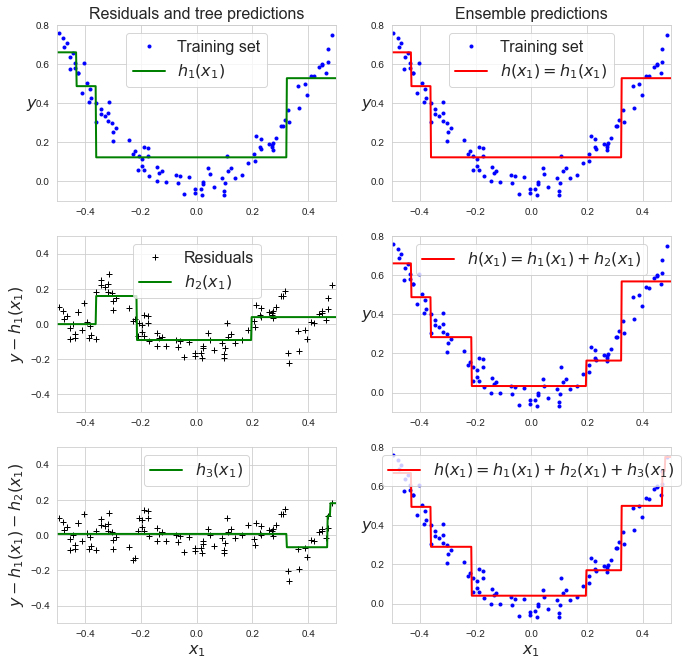

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
df = pd.read_csv("./titanic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId's missing values: 0.00 %
Survived's missing values: 0.00 %
Pclass's missing values: 0.00 %
Name's missing values: 0.00 %
Sex's missing values: 0.00 %
Age's missing values: 19.87 %
SibSp's missing values: 0.00 %
Parch's missing values: 0.00 %
Ticket's missing values: 0.00 %
Fare's missing values: 0.00 %
Cabin's missing values: 77.10 %
Embarked's missing values: 0.22 %


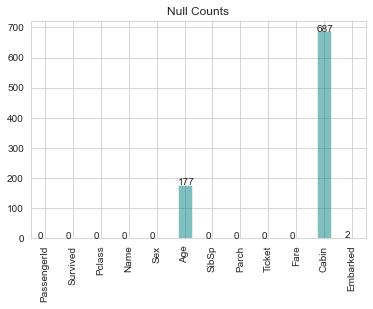

In [11]:

column_names = df.columns
null_cols=[]
total_length=len(df)
for column in column_names:
    missing_counts=df[column].isnull().sum()
    print(f"{column}'s missing values: {missing_counts/total_length*100:.2f} %")
    null_cols.append(missing_counts)

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax=df.isnull().sum().plot(kind='bar',color='teal',  alpha=0.5)

for p, val in zip(ax.patches,null_cols):
    x=p.get_x()
    y=p.get_y()+val
    ax.annotate(y,(x,y))
plt.title('Null Counts')
plt.show()

Missing columns are "Age" (numeric), "Cabin" (categorical), and "Embarked" (categorical). 
- "Age" can be filled with either median or mean, depending on data distribution (histogram).
- "Cabin" contains categorical values and is missing over 75%, so it would be discarded.
- "Embarked" can be filled with most common value. 

#### "Age" Imputation

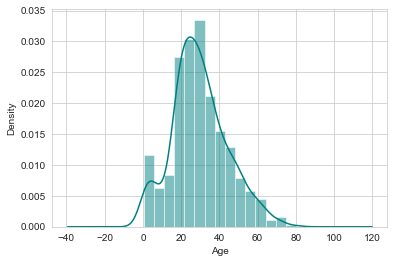

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax = df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.5)
df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.show()

because Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, using median is a better decision to impute the missing values.

In [13]:
# median age
age_median = df["Age"].median(skipna=True)
print(f'The median of "Age" is {age_median:.2f}')

The median of "Age" is 28.00


In [14]:
# replace median value
df["Age"].fillna(age_median, inplace=True)

#### "Cabin" Imputation

In [15]:
# drop columns
df.drop(columns=['Cabin'], inplace=True)
# check remained columns
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

#### "Embarked" Imputation

In [16]:
# count values
print('## Boarded passengers grouped by port of embarkation \n## where (C = Cherbourg, Q = Queenstown, S = Southampton):')
embarked_counts=df['Embarked'].value_counts()
print(embarked_counts)


## Boarded passengers grouped by port of embarkation 
## where (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


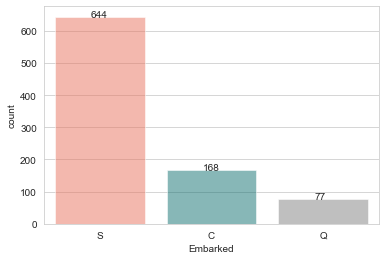

In [17]:
# create my own colormap
colors = ["tomato", "teal", "gray"]

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax=sns.countplot(x='Embarked', data=df, palette=colors, alpha=0.5)

for p, val in zip(ax.patches,embarked_counts):
    x=p.get_x()+p.get_width()/2.5
    y=p.get_y()+val
    ax.annotate(y,(x,y))
    
plt.show()

In [18]:
# replace mod value
most_common_embarked_value=df['Embarked'].value_counts().idxmax()
df["Embarked"].fillna(most_common_embarked_value, inplace=True)


In [19]:
# check nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [20]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [21]:
categ_df = df.select_dtypes(include='object')
print(f"Categorical Columns: {categ_df.columns.values}")
numer_df = df.select_dtypes(exclude='object')
print(f"Numerical Columns: {numer_df.columns.values}")

Categorical Columns: ['Name' 'Sex' 'Ticket' 'Embarked']
Numerical Columns: ['PassengerId' 'Survived' 'Pclass' 'Age' 'SibSp' 'Parch' 'Fare']


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [22]:
# Drop "Name", "Ticket" from Categ and Drop "PassengerId" from Numer
# Transform categorical data to dummy values. 
transformed_df = pd.DataFrame(df.drop(categ_df.columns,axis =1)).merge(pd.get_dummies(categ_df.drop(['Name','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(transformed_df.shape)
transformed_df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [23]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    uint8  
 7   Sex_male    891 non-null    uint8  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 46.2 KB


**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [24]:
X =transformed_df.loc[:, ~transformed_df.columns.isin(['Survived'])]
y =transformed_df['Survived']
X.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [25]:
# transform numerical values
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=0)


**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [27]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.813
Accuracy score (validation): 0.816

Learning rate:  0.1
Accuracy score (training): 0.816
Accuracy score (validation): 0.789

Learning rate:  0.25
Accuracy score (training): 0.832
Accuracy score (validation): 0.798

Learning rate:  0.5
Accuracy score (training): 0.846
Accuracy score (validation): 0.807

Learning rate:  0.75
Accuracy score (training): 0.844
Accuracy score (validation): 0.807

Learning rate:  1
Accuracy score (training): 0.846
Accuracy score (validation): 0.803



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [28]:
# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# instantiate model
model=GradientBoostingClassifier(max_features=2, random_state = 0)

# fit model
model.fit(X_train, y_train)

# define the grid search parameters
n_trees = [10, 20, 40, 60, 80, 100]
lr = [0.1,0.5,1,2]
md = [2,3,4]
param_grid = dict(n_estimators=n_trees, learning_rate=lr, max_depth=md)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(X_test, y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811592 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}
0.784685 (0.019779) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10}
0.811592 (0.019686) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}
0.789069 (0.028784) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 40}
0.784685 (0.012154) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}
0.789189 (0.013423) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80}
0.789129 (0.023808) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.798138 (0.012078) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
0.798078 (0.023030) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
0.793574 (0.024042) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}
0.807087 (0.017704) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}
0.802703 (0.016661) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_e

In [29]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names
class_names
labels=np.array(['no survived', 'survived'])
labels

array(['no survived', 'survived'], dtype='<U11')

###### sklearn Confusion Matrix ######
[[118  21]
 [ 26  58]]

###### Pandas 'crosstab' Confusion Matrix ######
Predicted    0   1  All
Actual                 
0          118  21  139
1           26  58   84
All        144  79  223

###### Classification report Confusion Matrix ######
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       139
           1       0.73      0.69      0.71        84

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223




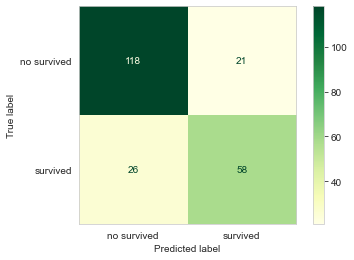

In [30]:
# best model
# Best: 0.811592 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}
best_model = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_features=2, max_depth = 2, random_state = 0)

# fit model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# sklearn Confusion Matrix
print("###### sklearn Confusion Matrix ######")
print(confusion_matrix(y_test,y_pred))
print()

# Pandas 'crosstab' displays a better formated confusion matrix.
# NOTE: inputs of y_test and y_pred must be np.array
print("###### Pandas 'crosstab' Confusion Matrix ######")
cm = pd.crosstab(np.array(y_test), np.array(y_pred), rownames=['Actual'], colnames=['Predicted'], margins=True)
print(cm) 
print()

print("###### Classification report Confusion Matrix ######")
print("Classification report:")
print(classification_report(y_test, y_pred))
print()

# fig,ax=plt.subplots(1,1,figsize=(4,4))
labels=np.array(['no survived', 'survived'])
plot_confusion_matrix(best_model,X_test,y_test,display_labels=labels,cmap=plt.cm.YlGn)
plt.ylabel="True Label"
plt.xlabel="Predicted Label"
plt.grid(False)
plt.show()


**<font color='teal'>Calculate the ROC for the model as well.</font>**

0.881466255566975


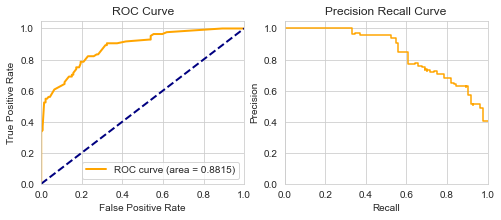

In [35]:
# store the predicted probabilities for class 1
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Get ROC curve FPR and TPR from true labels vs score values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Calculate precision and recall from true labels vs score values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

fig, axes= plt.subplots(1,2,figsize=(8, 3))

lw = 2
axes[0].plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True)

axes[1].step(recall, precision, color='orange', where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])
axes[1].set_title('Precision Recall Curve')
axes[1].grid(True)

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.5   # the amount of width reseaaarved for blank space between subplots
# hspace = 0.2   # the amount of height reserved for white space between subplots
# plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()